<a href="https://colab.research.google.com/github/achrisk/Dissertation/blob/main/within_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/achrisk/Dissertation.git

fatal: destination path 'Dissertation' already exists and is not an empty directory.


In [ ]:
import scipy.io as spio
import numpy as np
import pandas as pd
from importlib.machinery import SourceFileLoader
import pickle

# EEGNet-specific imports
from Dissertation.EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm#
from google.colab import files
from sklearn.metrics import cohen_kappa_score

K.set_image_data_format('channels_first')


from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.layers import SpatialDropout2D
K.set_image_data_format('channels_first')

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter

In [ ]:
# Band-pass Filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y



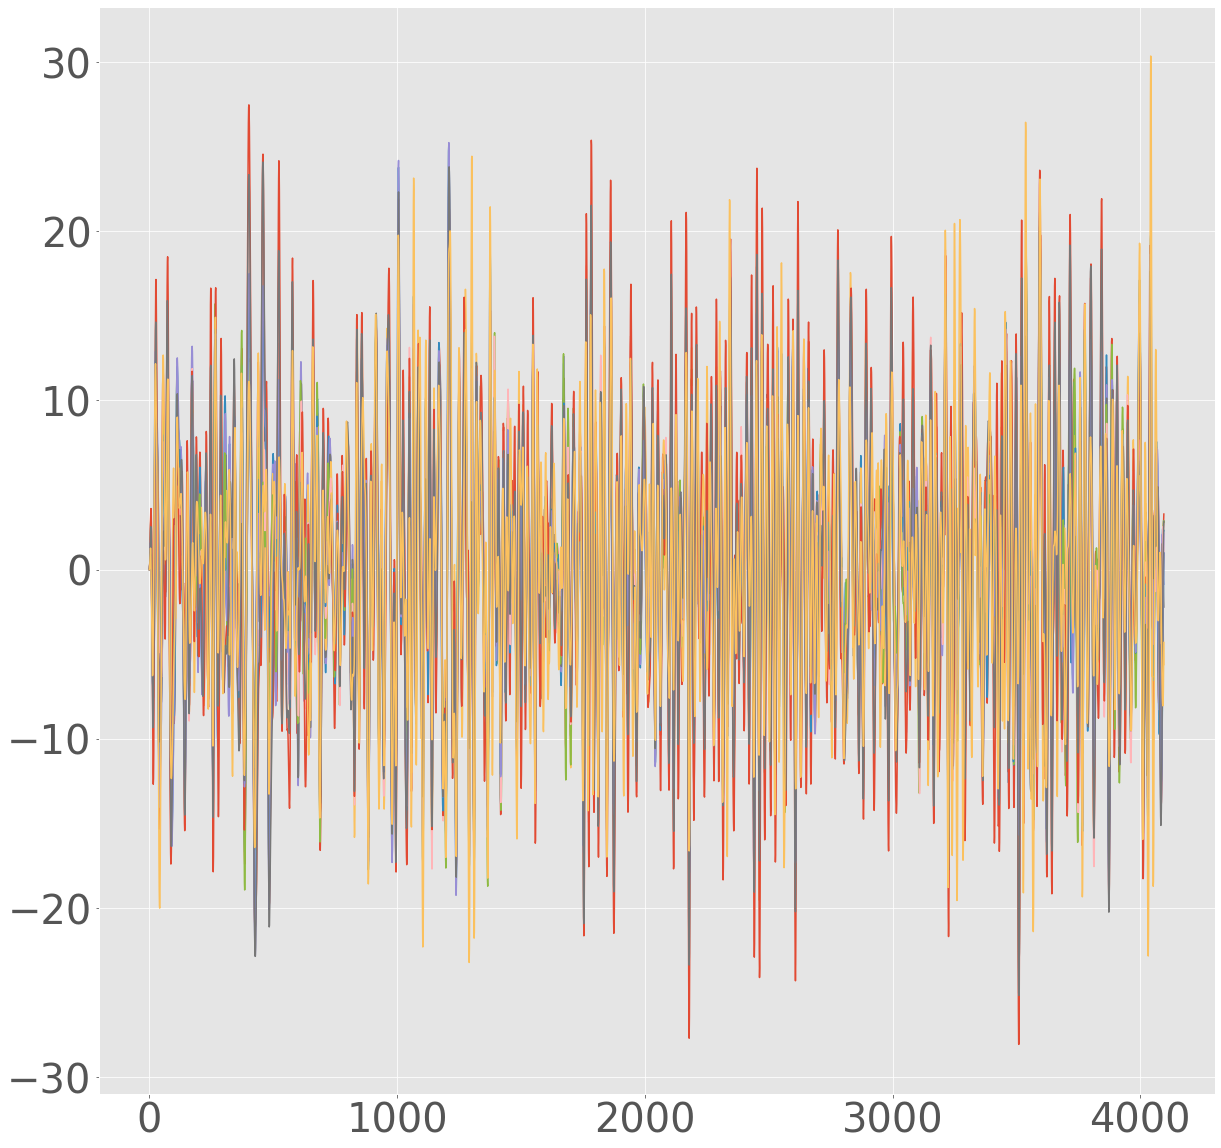

In [ ]:
####################### data exploration ######################################

K.clear_session()

X_tr = np.empty([80, 12, 4096])

nsub = 8

for sub_idx, x in enumerate(range(1,nsub+1)):
  fName = 'Dissertation/EEG data/parsed_P0' + str(x) + 'T.mat'  # Load Data
  mat = spio.loadmat(fName)
  r_X_tr = mat['RawEEGData']
  y_tr = mat['Labels']
  y_tr = y_tr.flatten() 

  for t in range(r_X_tr.shape[0]):
      tril = r_X_tr[t,:,:]
      #tril = tril.transpose()
      tril_filtered = butter_bandpass_filter(tril, lowcut=8, highcut=h, fs=512, order=4)
      # tril_filtered = tril_filtered.transpose()
      X_tr[t,:,:] = tril_filtered 
      
            
plt.figure(figsize=(20,20))
plt.xticks(size = 40)
plt.yticks(size = 40)
for i in range(np.shape(X_train)[2]):
  plt.plot(X_tr[:,i,:][0])

plt.show()

In [ ]:
#######   initialising DeepConvNet and ShallowConvNet methods in the same file for ease of changing kernel size for testing   #######


def DeepConvNet(nb_classes, Chans = 64, Samples = 256,
                dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(25, (1, 10), 
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 10),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 10),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 10),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)


# need these for ShallowConvNet
def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000)) 

def ShallowConvNet(nb_classes, Chans = 64, Samples = 128, dropoutRate = 0.5):
    """ Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), Human Brain Mapping.
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25    
    
    Note that this implementation has not been verified by the original 
    authors. We do note that this implementation reproduces the results in the
    original paper with minor deviations. 
    """

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(40, (1, 100), 
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(40, (Chans, 1), use_bias=False, 
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 35), strides=(1, 7))(block1)
    block1       = Activation(log)(block1)
    block1       = Dropout(dropoutRate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

In [ ]:
K.clear_session()

X_tr = np.empty([80, 12, 4096])
result=[]

h_cut = [18, 24, 30] # [only alpha, alpha + low beta, alpha + beta] 18, 24, 30
drop_out = [0.25, 0.5 ] # 0.25, 0.5
k_len = [32, 64, 128, 256] # 32, 64, 128, 256
n_epochs = 500
model_name = 'EEGNet'
kernels, chans, samples = 1, 12, 1536

outfname = 'accuray_epochs' + str(n_epochs) + '_k_len_' + str(k_len) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.pickle'
outfname_history = 'accuray_epochs' + str(n_epochs) + '_k_len_' + str(k_len) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'


nsub = 8
nfilt = len(h_cut)
ndrop = len(drop_out)
nkl = len(k_len)
acc_sub = np.zeros([nsub, nfilt,ndrop,nkl])
hyper_parameter_matrix = np.zeros([nsub, nfilt, ndrop, nkl, 5])
history = {}

kappa_statistic_per_patient = {}
kappa_scores= []
accuracy_scores= []



for sub_idx, x in enumerate(range(1,nsub+1)):
    for h_indx, h in enumerate(h_cut):
        fName = 'Dissertation/EEG data/parsed_P0' + str(x) + 'T.mat'  # Load Data
        print(fName)
        mat = spio.loadmat(fName)
        r_X_tr = mat['RawEEGData']
        y_tr = mat['Labels']
        y_tr = y_tr.flatten() 

        print(np.shape(r_X_tr))
        print(np.shape(y_tr))

        for t in range(r_X_tr.shape[0]):
            tril = r_X_tr[t,:,:]
            #tril = tril.transpose()
            tril_filtered = butter_bandpass_filter(tril, lowcut=8, highcut=h, fs=512, order=4)
            # tril_filtered = tril_filtered.transpose()
            X_tr[t,:,:] = tril_filtered 

        indices = np.random.permutation(X_tr.shape[0])
        X_tr = X_tr[indices, :, :]
        y_tr = y_tr[indices]
        # split data of each subject in training and validation
        X_train = X_tr[0:55,:,2048:3584]
        Y_train = y_tr[0:55]
        X_val = X_tr[55:70,:,2048:3584]
        Y_val = y_tr[55:70]
        X_test = X_tr[70:,:,2048:3584]
        Y_test = y_tr[70:]

        


        print(np.shape(X_train))
        print(np.shape(Y_train))
        print(np.shape(X_val))
        print(np.shape(Y_val))
        print(np.shape(X_test))
        print(np.shape(Y_test))

        # convert labels to one-hot encodings.
        Y_train = np_utils.to_categorical(Y_train-1, num_classes=2)
        Y_val = np_utils.to_categorical(Y_val-1, num_classes=2)
        Y_test = np_utils.to_categorical(Y_test-1, num_classes=2)

        # convert data to NCHW (trials, kernels, channels, samples) format. Data 
        # contains 22 channels and 500 time-points. Set the number of kernels to 1.
        X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
        X_val = X_val.reshape(X_val.shape[0], kernels, chans, samples)
        X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

       

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_val.shape[0], 'val samples')

        print('X_train shape:', X_test.shape)
        print(X_test.shape[0], 'test samples')
        plt.figure(figsize=(20,20))
        

        #for i in range(np.shape(X_train)[2]):
          #plt.plot(X_train[0,:,i,:][0])
        #plt.show()
       

        for id_d, d in enumerate(drop_out):
            for id_kl, kl in enumerate(k_len):
              print(id_kl, id_d)
              # configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
              # model configurations may do better, but this is a good starting point)
              model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples,
                             dropoutRate = d, kernLength = kl, F1 = 8,D = 2, F2 = 16,
                             norm_rate = 0.25, dropoutType = 'Dropout')
              #model.add_metric(tfa.metrics.CohenKappa(num_classes=2), name = 'kappa') #remove later

              # compile the model and set the optimizers
              model.compile(loss='categorical_crossentropy', optimizer='adam', 
                            metrics = ['accuracy'])

              # count number of parameters in the model
              numParams    = model.count_params() 

              # set a valid path for your system to record model checkpoints
              checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

              # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
              # the weights all to be 1
              class_weights = {0:1, 1:1}

              history_temp = model.fit(X_train, Y_train, batch_size = 16, epochs = n_epochs, 
                              verbose = 2, validation_data=(X_val, Y_val),
                              callbacks=[checkpointer], class_weight = class_weights)
          
              history[sub_idx,h_indx,id_d] = history_temp.history

              print('\n# Evaluate on test data')


              results = model.evaluate(X_test, Y_test)
              print('test loss, test acc:', results)


              predictions = model.predict(x=X_test)
              assert predictions.shape == Y_test.shape
              kappa_statistic_per_patient[sub_idx,h_indx,id_d, id_kl] = cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1))
              print (kappa_statistic_per_patient)
              
             
              
          



              print(results)
              acc_sub[sub_idx,h_indx,id_d, id_kl] = results[1]
              hyper_parameter_matrix[sub_idx,h_indx,id_d, id_kl, :] = [x, h, d, kl, results[1]]

              accuracy_scores.append(results[1])
              #print (accuracy_scores)


              K.clear_session()
              del checkpointer, model


##### kappa statistic values and graph 
for key in kappa_statistic_per_patient:
  
  kappa_scores.append(kappa_statistic_per_patient[key])
  

plt.style.use('ggplot')
 
x_pos = ( 1, 2, 3, 4, 5, 6, 7, 8)
plt.xticks(size = 25)
plt.yticks(size = 25)
plt.bar(x_pos, kappa_scores, color='green')
plt.xlabel("Subjects")
plt.ylabel("Kappa Score")


plt.show()

#plt.bar(x_pos, accuracy_scores, color ='green')
#plt.xlabel("Subjects")
#plt.ylabel("Accuracy")
#plt.show()




#####  pickling the data for later use etc.
with open(outfname, 'wb') as handle:
    pickle.dump(hyper_parameter_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)         
with open(outfname_history, 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

files.download('accuray_epochs' + str(n_epochs) + '_k_len_' + str(k_len) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.pickle') 
files.download('accuray_epochs' + str(n_epochs) + '_k_len_' + str(k_len) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle') 



In [ ]:
###### code to open pickled files and present results ######

from google.colab import files

#h_cut = [30] # [only alpha, alpha + low beta, alpha + beta]
#drop_out = [0.25]
#n_epochs = 500
#k_len = [64]
model_name = 'EEGNet'  # ShallowConvNet or DeepConvNet
kernels, chans, samples = 1, 12, 1536
subject = 1
outfname_history = 'accuray_epochs' + str(n_epochs) + '_k_len_' + str(k_len) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'

with open(outfname_history, 'rb') as handle:
    history = pickle.load(handle)

with open(outfname, 'rb') as handle:
    hyper_parameter_matrix = pickle.load(handle)

ind = np.unravel_index(np.argmax(acc_sub, axis=None), acc_sub.shape) #index of optimal hyperparameters
acc_sub
hyper_parameter_matrix
hyper_parameter_matrix[ind] #accuracy of optimal model (i.e. best hyperparameters)
reduced_acc_sub = np.mean(acc_sub, axis=0, keepdims=True) #mean across patients per given selection of hyperparameters
hyper_parameter_matrix_sub = np.mean(hyper_parameter_matrix, axis=0, keepdims=True) #mean across patients per given selection of hyperparameters

sem_acc = np.std(acc_sub, axis=0, keepdims=True) #std across patients per given selection of hyperparameters

ind_reduced = np.unravel_index(np.argmax(reduced_acc_sub, axis=None), reduced_acc_sub.shape) #index for best hyperparameter selection for best mean accuracy across patients
#print('Index is: {}'.format(ind_reduced[-1]))
#print('Hyperparameters are: {}'.format(hyper_parameter_matrix[ind_reduced]))
#print(hyper_parameter_matrix[ind_reduced])

#print(acc_sub)



#print(reduced_acc_sub)
print(hyper_parameter_matrix_sub)
#print(sem_acc)



#for key in history.keys():
#  plt.figure()
#  history_ = history[key]
#  plt.plot(history_['accuracy'])
#  plt.plot(history_['val_accuracy'])
#  plt.ylabel('accuracy')
#  plt.xlabel('epoch no.')
#  plt.legend(['train', 'valid'], loc='upper left')
#  plt.show()
#  plt.savefig('accuracy_epochs' + str(n_epochs) +  '_k_len_' + str(k_len)  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + 'subject '+str(subject)+'.jpeg')
 #files.download('accuracy_epochs' + str(n_epochs) + '_k_len_' + str(k_len)  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + 'subject '+str(subject)+'.jpeg')


In [ ]:
K.clear_session()

X_tr = np.empty([80, 12, 4096])
result=[]

h_cut = [18, 24, 30] # [only alpha, alpha + low beta, alpha + beta]
drop_out = [0.25, 0.5]
n_epochs = 500
model_name = 'DeepConvNet'  # ShallowConvNet or DeepConvNet
kernels, chans, samples = 1, 12, 1536

outfname = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.pickle'
outfname_history = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'

nsub = 8
nfilt = len(h_cut)
ndrop = len(drop_out)
acc_sub = np.zeros([nsub, nfilt,ndrop])
hyper_parameter_matrix = np.zeros([nsub, nfilt, ndrop, 4])
history={}

for sub_idx, x in enumerate(range(1,nsub+1)):
    for h_indx, h in enumerate(h_cut):
        fName = 'Dissertation/EEG data/parsed_P0' + str(x) + 'T.mat'  # Load Data
        print(fName)
        mat = spio.loadmat(fName)
        r_X_tr = mat['RawEEGData']
        y_tr = mat['Labels']
        y_tr = y_tr.flatten() 

        print(np.shape(r_X_tr))
        print(np.shape(y_tr))

        for t in range(r_X_tr.shape[0]):
            tril = r_X_tr[t,:,:]
            #tril = tril.transpose()
            tril_filtered = butter_bandpass_filter(tril, lowcut=8, highcut=h, fs=512, order=4)
            # tril_filtered = tril_filtered.transpose()
            X_tr[t,:,:] = tril_filtered 

        indices = np.random.permutation(X_tr.shape[0])
        X_tr = X_tr[indices, :, :]
        y_tr = y_tr[indices]
        # split data of each subject in training and validation
        X_train = X_tr[0:55,:,2048:3584]
        Y_train = y_tr[0:55]
        X_val = X_tr[55:70,:,2048:3584]
        Y_val = y_tr[55:70]
        X_test = X_tr[70:,:,2048:3584]
        Y_test = y_tr[70:]

        print(np.shape(X_train))
        print(np.shape(Y_train))
        print(np.shape(X_val))
        print(np.shape(Y_val))
        print(np.shape(X_test))
        print(np.shape(Y_test))

        # convert labels to one-hot encodings.
        Y_train = np_utils.to_categorical(Y_train-1, num_classes=2)
        Y_val = np_utils.to_categorical(Y_val-1, num_classes=2)
        Y_test = np_utils.to_categorical(Y_test-1, num_classes=2)

        # convert data to NCHW (trials, kernels, channels, samples) format. Data 
        # contains 22 channels and 500 time-points. Set the number of kernels to 1.
        X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
        X_val = X_val.reshape(X_val.shape[0], kernels, chans, samples)
        X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_val.shape[0], 'val samples')

        print('X_train shape:', X_test.shape)
        print(X_test.shape[0], 'test samples')

        for id_d, d in enumerate(drop_out):
          print(id_d)
          
          if model_name == 'DeepConvNet':
            model = DeepConvNet(nb_classes=2, Chans = chans, Samples = samples, dropoutRate = d)
          elif model_name == 'ShallowConvNet':
            model = ShallowConvNet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = d)
          else:
            raise ValueError('Model name wrong!')
          

          # compile the model and set the optimizers
          model.compile(loss='categorical_crossentropy', optimizer='adam', 
                        metrics = ['accuracy'])

          # count number of parameters in the model
          numParams    = model.count_params() 

          # set a valid path for your system to record model checkpoints
          checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

          # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
          # the weights all to be 1
          class_weights = {0:1, 1:1}

          history_temp = model.fit(X_train, Y_train, batch_size = 16, epochs = n_epochs, 
                              verbose = 2, validation_data=(X_val, Y_val),
                              callbacks=[checkpointer], class_weight = class_weights)
          
          history[sub_idx,h_indx,id_d] = history_temp.history

          print('\n# Evaluate on test data')


          results = model.evaluate(X_test, Y_test)
          print('test loss, test acc:', results)

          print(results)
          acc_sub[sub_idx,h_indx,id_d] = results[1]
          hyper_parameter_matrix[sub_idx,h_indx,id_d, :] = [x, h, d, results[1]]

          K.clear_session()
with open(outfname, 'wb') as handle:
    pickle.dump(hyper_parameter_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)         
with open(outfname_history, 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)      

files.download('accuray_epochs' + str(n_epochs) +  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.pickle') 
files.download('accuray_epochs' + str(n_epochs) +  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle') 


In [ ]:
###### code to open pickled files and present results ######



from google.colab import files

#h_cut = [30] # [only alpha, alpha + low beta, alpha + beta]
#drop_out = [0.25]
#n_epochs = 500
#k_len = [64]
model_name = 'DeepConvNet'  # ShallowConvNet or DeepConvNet
kernels, chans, samples = 1, 12, 1536
subject = 1
outfname_history = 'accuray_epochs' + str(n_epochs) + '_k_len_' + str(k_len) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'

with open(outfname_history, 'rb') as handle:
    history = pickle.load(handle)

with open(outfname, 'rb') as handle:
    hyper_parameter_matrix = pickle.load(handle)

ind = np.unravel_index(np.argmax(acc_sub, axis=None), acc_sub.shape) #index of optimal hyperparameters
acc_sub
hyper_parameter_matrix
hyper_parameter_matrix[ind] #accuracy of optimal model (i.e. best hyperparameters)
reduced_acc_sub = np.mean(acc_sub, axis=0, keepdims=True) #mean across patients per given selection of hyperparameters
hyper_parameter_matrix_sub = np.mean(hyper_parameter_matrix, axis=0, keepdims=True) #mean across patients per given selection of hyperparameters

sem_acc = np.std(acc_sub, axis=0, keepdims=True) #std across patients per given selection of hyperparameters

ind_reduced = np.unravel_index(np.argmax(reduced_acc_sub, axis=None), reduced_acc_sub.shape) #index for best hyperparameter selection for best mean accuracy across patients
#print('Index is: {}'.format(ind_reduced[-1]))
#print('Hyperparameters are: {}'.format(hyper_parameter_matrix[ind_reduced]))
#print(hyper_parameter_matrix[ind_reduced])

#print(acc_sub)



#print(reduced_acc_sub)
print(hyper_parameter_matrix_sub)
#print(sem_acc)



#for key in history.keys():
#  plt.figure()
#  history_ = history[key]
#  plt.plot(history_['accuracy'])
#  plt.plot(history_['val_accuracy'])
#  plt.ylabel('accuracy')
#  plt.xlabel('epoch no.')
#  plt.legend(['train', 'valid'], loc='upper left')
#  plt.show()
#  plt.savefig('accuracy_epochs' + str(n_epochs) +  '_k_len_' + str(k_len)  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + 'subject '+str(subject)+'.jpeg')
 #files.download('accuracy_epochs' + str(n_epochs) + '_k_len_' + str(k_len)  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + 'subject '+str(subject)+'.jpeg')
#  subject += 1

In [ ]:
K.clear_session()

X_tr = np.empty([80, 12, 4096])
result=[]

h_cut = [18, 24, 30] # [only alpha, alpha + low beta, alpha + beta]
drop_out = [0.25, 0.5]
n_epochs =  100
model_name = 'ShallowConvNet'  # ShallowConvNet or DeepConvNet
kernels, chans, samples = 1, 12, 1536

outfname = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.pickle'
outfname_history = 'accuray_epochs' + str(n_epochs) + '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'

nsub = 8
nfilt = len(h_cut)
ndrop = len(drop_out)
acc_sub = np.zeros([nsub, nfilt,ndrop])
hyper_parameter_matrix = np.zeros([nsub, nfilt, ndrop, 4])
history={}

for sub_idx, x in enumerate(range(1,nsub+1)):
    for h_indx, h in enumerate(h_cut):
        fName = 'Dissertation/EEG data/parsed_P0' + str(x) + 'T.mat'  # Load Data
        print(fName)
        mat = spio.loadmat(fName)
        r_X_tr = mat['RawEEGData']
        y_tr = mat['Labels']
        y_tr = y_tr.flatten() 

        print(np.shape(r_X_tr))
        print(np.shape(y_tr))


        for t in range(r_X_tr.shape[0]):
            tril = r_X_tr[t,:,:]
            #tril = tril.transpose()
            tril_filtered = butter_bandpass_filter(tril, lowcut=8, highcut=h, fs=512, order=4)
            # tril_filtered = tril_filtered.transpose()
            X_tr[t,:,:] = tril_filtered 


        indices = np.random.permutation(X_tr.shape[0])
        X_tr = X_tr[indices, :, :]
        y_tr = y_tr[indices]

        # split data of each subject in training and validation
        X_train = X_tr[0:55,:,2048:3584]
        Y_train = y_tr[0:55]
        X_val = X_tr[55:70,:,2048:3584]
        Y_val = y_tr[55:70]
        X_test = X_tr[70:,:,2048:3584]
        Y_test = y_tr[70:]

        print(np.shape(X_train))
        print(np.shape(Y_train))
        print(np.shape(X_val))
        print(np.shape(Y_val))
        print(np.shape(X_test))
        print(np.shape(Y_test))

        # convert labels to one-hot encodings.
        Y_train = np_utils.to_categorical(Y_train-1, num_classes=2)
        Y_val = np_utils.to_categorical(Y_val-1, num_classes=2)
        Y_test = np_utils.to_categorical(Y_test-1, num_classes=2)

        # convert data to NCHW (trials, kernels, channels, samples) format. Data 
        # contains 22 channels and 500 time-points. Set the number of kernels to 1.
        X_train = X_train.reshape(X_train.shape[0], kernels, chans, samples)
        X_val = X_val.reshape(X_val.shape[0], kernels, chans, samples)
        X_test = X_test.reshape(X_test.shape[0], kernels, chans, samples)

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_val.shape[0], 'val samples')

        print('X_train shape:', X_test.shape)
        print(X_test.shape[0], 'test samples')

        for id_d, d in enumerate(drop_out):
          print(id_d)
          
          if model_name == 'DeepConvNet':
            model = DeepConvNet(nb_classes=2, Chans = chans, Samples = samples, dropoutRate = d)
          elif model_name == 'ShallowConvNet':
            model = ShallowConvNet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = d)
          else:
            raise ValueError('Model name wrong!')
          

          # compile the model and set the optimizers
          model.compile(loss='categorical_crossentropy', optimizer='adam', 
                        metrics = ['accuracy'])

          # count number of parameters in the model
          numParams    = model.count_params() 

          # set a valid path for your system to record model checkpoints
          checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

          # the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
          # the weights all to be 1
          class_weights = {0:1, 1:1}

          history_temp = model.fit(X_train, Y_train, batch_size = 16, epochs = n_epochs, 
                              verbose = 2, validation_data=(X_val, Y_val),
                              callbacks=[checkpointer], class_weight = class_weights)
          
          history[sub_idx,h_indx,id_d] = history_temp.history

          print('\n# Evaluate on test data')


          results = model.evaluate(X_test, Y_test)
          print('test loss, test acc:', results)

          print(results)
          acc_sub[sub_idx,h_indx,id_d] = results[1]
          hyper_parameter_matrix[sub_idx,h_indx,id_d, :] = [x, h, d, results[1]]

          K.clear_session()
with open(outfname, 'wb') as handle:
    pickle.dump(hyper_parameter_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)         
with open(outfname_history, 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)   

files.download('accuray_epochs' + str(n_epochs) +  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_patient_data.pickle') 
files.download('accuray_epochs' + str(n_epochs) +  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle') 
   


In [ ]:
###### code to open pickled files and present results ######



from google.colab import files

#h_cut = [30] # [only alpha, alpha + low beta, alpha + beta]
#drop_out = [0.25]
#n_epochs = 500
#k_len = [64]
model_name = 'ShallowConvNet'  # ShallowConvNet or DeepConvNet
kernels, chans, samples = 1, 12, 1536
subject = 1
outfname_history = 'accuray_epochs' + str(n_epochs) +  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + '_history_data.pickle'

with open(outfname_history, 'rb') as handle:
    history = pickle.load(handle)

with open(outfname, 'rb') as handle:
    hyper_parameter_matrix = pickle.load(handle)

ind = np.unravel_index(np.argmax(acc_sub, axis=None), acc_sub.shape) #index of optimal hyperparameters
acc_sub
hyper_parameter_matrix
hyper_parameter_matrix[ind] #accuracy of optimal model (i.e. best hyperparameters)
reduced_acc_sub = np.mean(acc_sub, axis=0, keepdims=True) #mean across patients per given selection of hyperparameters
hyper_parameter_matrix_sub = np.mean(hyper_parameter_matrix, axis=0, keepdims=True) #mean across patients per given selection of hyperparameters

sem_acc = np.std(acc_sub, axis=0, keepdims=True) #std across patients per given selection of hyperparameters

ind_reduced = np.unravel_index(np.argmax(reduced_acc_sub, axis=None), reduced_acc_sub.shape) #index for best hyperparameter selection for best mean accuracy across patients
#print('Index is: {}'.format(ind_reduced[-1]))
#print('Hyperparameters are: {}'.format(hyper_parameter_matrix[ind_reduced]))
#print(hyper_parameter_matrix[ind_reduced])

#print(acc_sub)



#print(reduced_acc_sub)
print(hyper_parameter_matrix_sub)
#print(sem_acc)



#for key in history.keys():
#  plt.figure()
#  history_ = history[key]
#  plt.plot(history_['accuracy'])
#  plt.plot(history_['val_accuracy'])
#  plt.ylabel('accuracy')
#  plt.xlabel('epoch no.')
#  plt.legend(['train', 'valid'], loc='upper left')
#  plt.show()
#  plt.savefig('accuracy_epochs' + str(n_epochs) +  '_k_len_' + str(k_len)  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + 'subject '+str(subject)+'.jpeg')
 #files.download('accuracy_epochs' + str(n_epochs) + '_k_len_' + str(k_len)  '_filter_' + str(h_cut) + '_drop_' + str(drop_out) + '_model_' + str(model_name) + 'subject '+str(subject)+'.jpeg')
#  subject += 1

[[[[ 4.5        18.          0.25        0.5       ]
   [ 4.5        18.          0.5         0.4625    ]]

  [[ 4.5        24.          0.25        0.5       ]
   [ 4.5        24.          0.5         0.58750001]]

  [[ 4.5        30.          0.25        0.675     ]
   [ 4.5        30.          0.5         0.7       ]]]]
